In [432]:
import numpy as np
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import nni

In [433]:
def func(x,y):
    return np.cos(2*x + y)

In [434]:
def grad_func(x,y):
    return np.array([-2*np.sin(2*x + y), -np.sin(2*x + y)])

In [435]:
X_interval = np.array([0.0, np.pi/2])
Y_interval = np.array([0.0, np.pi/2])
numpoints = 2500
noise = 0.0
X_datapoints = np.random.uniform(*X_interval, numpoints)
Y_datapoints = np.random.uniform(*Y_interval, numpoints)

In [436]:
gridpoints = 101
X_grid = np.linspace(*X_interval, gridpoints)
Y_grid = np.linspace(*X_interval, gridpoints)

In [437]:
func_values = np.zeros((gridpoints,gridpoints))
grad_values = np.zeros((2,gridpoints,gridpoints))

for i,x in enumerate(X_grid):
    for j,y in enumerate(Y_grid):
        func_values[i,j] = func(x,y)
        grad_values[:,i,j] = grad_func(x,y)

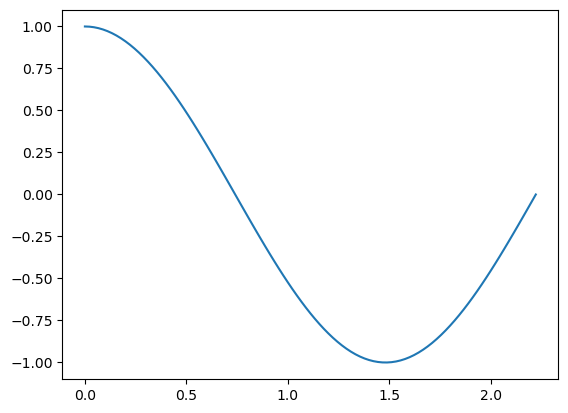

In [438]:
plt.plot(X_grid*np.sqrt(2),func(X_grid,Y_grid))

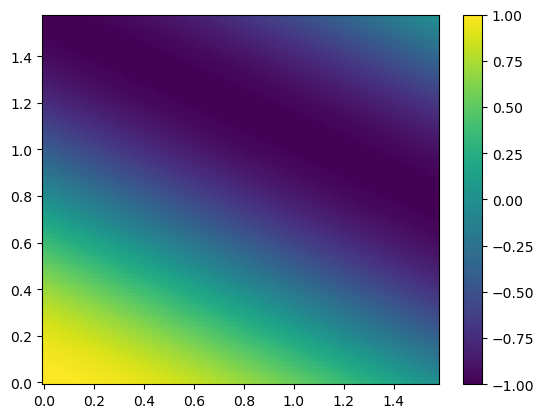

In [439]:
plt.pcolormesh(X_grid,Y_grid,func_values)
plt.colorbar()

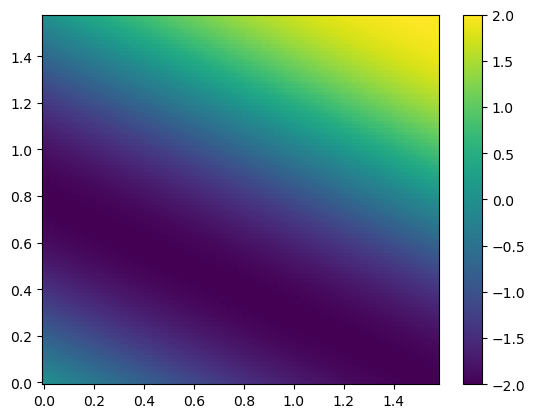

In [440]:
plt.pcolormesh(X_grid,Y_grid,grad_values[0])
plt.colorbar()

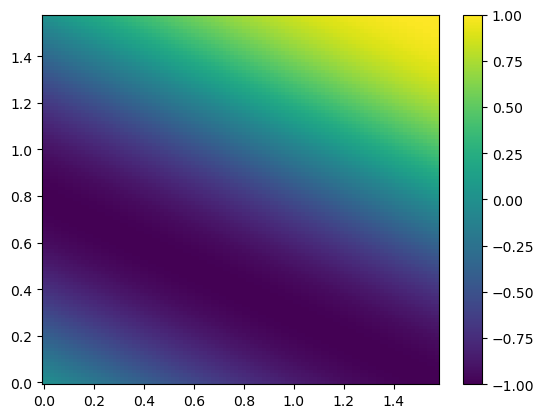

In [441]:
plt.pcolormesh(X_grid,Y_grid,grad_values[1])
plt.colorbar()

In [442]:
activation_function = "tanh"
model = MLPRegressor((100,),activation=activation_function,solver="lbfgs")

In [443]:
training_features = np.array([X_datapoints,Y_datapoints])
training_labels = grad_func(X_datapoints,Y_datapoints)

model.fit(training_features.T,training_labels.T)

d:\anaconda3\envs\bayesopt\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='tanh', solver='lbfgs')

In [444]:
prediction = np.zeros((2,gridpoints,gridpoints))
for i,x in enumerate(X_grid):
    points = np.array([np.ones(gridpoints)*x, Y_grid])
    prediction[:,i] = model.predict(points.T).T

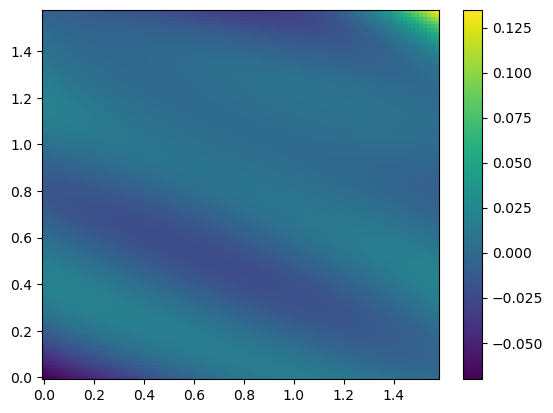

In [445]:
plt.pcolormesh(X_grid,Y_grid,prediction[0]-grad_values[0])
plt.colorbar()

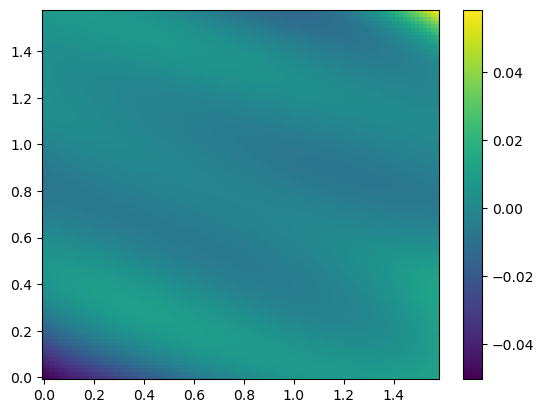

In [446]:
plt.pcolormesh(X_grid,Y_grid,prediction[1]-grad_values[1])
plt.colorbar()

In [447]:
integral_diag = np.zeros_like(X_grid)
integral_x = np.zeros_like(X_grid)
integral_y = np.zeros_like(X_grid)

for i,x in enumerate(X_grid[1:]):
    bounds_diag = np.array([[0,0],[x,x]])
    bounds_x = np.array([[0,0],[x,0]])
    bounds_y = np.array([[0,0],[0,x]])
    integral_diag[i+1] = nni.integrate_ND_1L(bounds_diag,model.coefs_,model.intercepts_,activation_function)
    integral_x[i+1] = nni.integrate_ND_1L(bounds_x,model.coefs_,model.intercepts_,activation_function)
    integral_y[i+1] = nni.integrate_ND_1L(bounds_y,model.coefs_,model.intercepts_,activation_function)

# bounds = np.array([[0,0],[0,np.pi/2]])
bounds = np.array([[0,0],[np.pi/2,np.pi/2]])

integral = nni.integrate_ND_1L(bounds,model.coefs_,model.intercepts_,activation_function)

In [448]:
print(integral)

-1.000764717382217


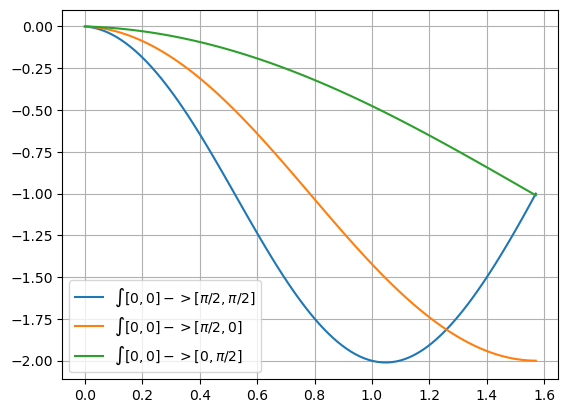

In [449]:
plt.plot(X_grid,integral_diag,label="$\int[0,0]->[\pi/2,\pi/2]$")
plt.plot(X_grid,integral_x,label="$\int[0,0]->[\pi/2,0]$")
plt.plot(X_grid,integral_y,label="$\int[0,0]->[0,\pi/2]$")
plt.legend()
plt.grid()

## Tests

In [450]:
# print("bounds: ")
# print(bounds[0])
# print(bounds[1])

# weight1 = model.coefs_[0]
# weight2 = model.coefs_[1]

# print("weights: ")
# print(weight1)
# print(weight2)

# biases = model.intercepts_
# print("biases: ")
# print(biases[0])
# print(biases[1])

# lowerbounds = weight1.T@bounds[0] + biases[0]
# upperbounds = weight1.T@bounds[1] + biases[0]
# divisors = upperbounds - lowerbounds

# print("integral bounds: ")
# print(lowerbounds)
# print(upperbounds)
# print("divisor:")
# print(divisors)

# integral_vector = np.zeros_like(divisors)

# integral_vector[divisors != 0] = \
#     (nni.int_relu(upperbounds[divisors != 0]) - nni.int_relu(lowerbounds[divisors != 0])) / divisors[divisors != 0]

# integral_vector[divisors == 0] = nni.relu(lowerbounds[divisors==0])

# print(integral_vector)

# integral = (bounds[1] - bounds[0]).T@weight2.T@integral_vector + (bounds[1] - bounds[0]).T@biases[1]